# Ungraded Lab: Implement a Siamese network

This lab will go through creating and training a multi-input model. You will build a basic Siamese Network to find the similarity or dissimilarity between items of clothing. For Week 1, you will just focus on constructing the network. You will revisit this lab in Week 2 when we talk about custom loss functions.

## Imports

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

## Prepare the Dataset

First define a few utilities for preparing and visualizing your dataset.

In [2]:
def create_pairs(x: np.ndarray, digit_indices: list) -> tuple:
    """Positive and negative pair creation.
    Alternates between positive and negative pairs.
    """
    pairs: list = []
    labels: list = []
    n: int = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
            z1: np.ndarray
            z2: np.ndarray
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc: int = random.randrange(1, 10)
            dn: int = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]

    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images: np.ndarray, labels: np.ndarray) -> tuple:
    digit_indices: list = [np.where(labels == i)[0] for i in range(10)]
    pairs: np.ndarray
    y: np.ndarray
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype("float32")

    return pairs, y


def show_image(image: list) -> None:
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show();

You can now download and prepare our train and test sets. You will also create pairs of images that will go into the multi-input model.

In [3]:
# load the dataset
train_images: np.ndarray
train_labels: np.ndarray
test_images: np.ndarray
test_labels: np.ndarray
(train_images, train_labels), (
    test_images,
    test_labels,
) = fashion_mnist.load_data()

# prepare train and test sets
train_images: np.ndarray = train_images.astype("float32")
test_images: np.ndarray = test_images.astype("float32")

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs: np.ndarray
tr_y: np.ndarray
ts_pairs: np.ndarray
ts_y: np.ndarray
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4423680/4422102 [==============================] - 0s 0us/step


You can see a sample pair of images below.

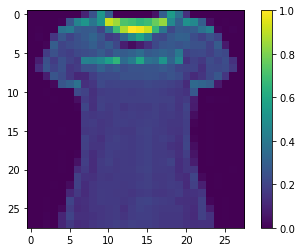

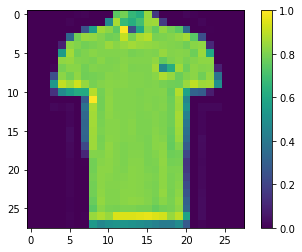

1.0


In [4]:
# array index
this_pair: int = 8

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair]);

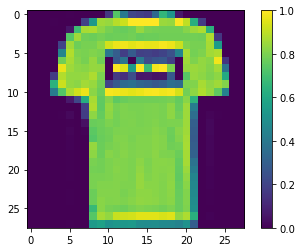

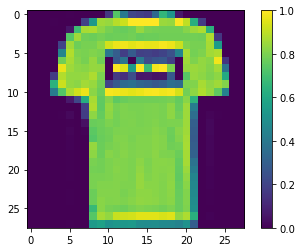

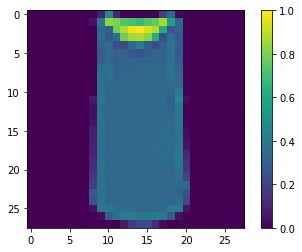

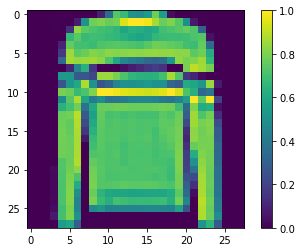

In [5]:
# print other pairs

show_image(tr_pairs[:, 0][0])
show_image(tr_pairs[:, 0][1])

show_image(tr_pairs[:, 1][0])
show_image(tr_pairs[:, 1][1]);

## Build the Model

Next, you'll define some utilities for building our model.

In [6]:
def initialize_base_network() -> tf.keras.Model:
    input: tf.keras.layers.Layer = Input(
        shape=(
            28,
            28,
        ),
        name="base_input",
    )
    x: tf.keras.layers.Layer = Flatten(name="flatten_input")(input)
    x = Dense(128, activation="relu", name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation="relu", name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation="relu", name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects: tf.Tensor) -> tf.Tensor:
    x: tf.Tensor
    y: tf.Tensor
    x, y = vects
    sum_square: tf.Tensor = K.sum(
        K.square(tf.subtract(x=x, y=y)), axis=1, keepdims=True
    )
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes) -> tuple:
    shape1, shape2 = shapes
    return (shape1[0], 1);

Let's see how our base network looks. This is where the two inputs will pass through to generate an output vector.

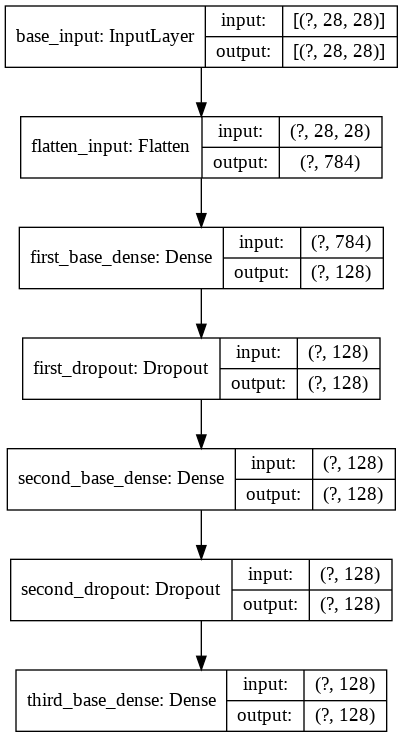

In [7]:
base_network = initialize_base_network()
plot_model(
    base_network,
    show_shapes=True,
    show_layer_names=True,
    to_file="base-model.png",
)

Let's now build the Siamese network. The plot will show two inputs going to the base network.

In [8]:
# create the left input and point to the base network
input_a: tf.keras.layers.Layer = Input(
    shape=(
        28,
        28,
    ),
    name="left_input",
)
vect_output_a: tf.keras.Model = base_network(input_a)

# create the right input and point to the base network
input_b: tf.keras.layers.Layer = Input(
    shape=(
        28,
        28,
    ),
    name="right_input",
)
vect_output_b: tf.keras.Model = base_network(input_b)

# measure the similarity of the two vector outputs
output: tf.keras.layers.Layer = Lambda(
    euclidean_distance,
    name="output_layer",
    output_shape=eucl_dist_output_shape,
)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model: tf.keras.Model = Model([input_a, input_b], output)

# plot model graph
plot_model(
    model, show_shapes=True, show_layer_names=True, to_file="outer-model.png"
);

## Train the Model

You can now define the custom loss for our network and start training.

In [9]:
def contrastive_loss_with_margin(
    margin: float,
) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    def contrastive_loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        square_pred: tf.Tensor = K.square(y_pred)
        margin_square: tf.Tensor = K.square(K.maximum(margin - y_pred, 0))
        return (
            tf.multiply(x=y_true, y=square_pred) + (1 - y_true) * margin_square
        )

    return contrastive_loss

In [10]:
rms: RMSprop = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history: tf.keras.callbacks.History = model.fit(
    [tr_pairs[:, 0], tr_pairs[:, 1]],
    tr_y,
    epochs=20,
    batch_size=128,
    validation_data=([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y),
);

Train on 119980 samples, validate on 19980 samples
Epoch 1/20
119980/119980 [==============================] - 9s 76us/sample - loss: 0.1115 - val_loss: 0.0835
Epoch 2/20
119980/119980 [==============================] - 8s 70us/sample - loss: 0.0794 - val_loss: 0.0727
Epoch 3/20
119980/119980 [==============================] - 8s 69us/sample - loss: 0.0704 - val_loss: 0.0761
Epoch 4/20
119980/119980 [==============================] - 8s 69us/sample - loss: 0.0655 - val_loss: 0.0711
Epoch 5/20
119980/119980 [==============================] - 8s 70us/sample - loss: 0.0622 - val_loss: 0.0676
Epoch 6/20
119980/119980 [==============================] - 8s 70us/sample - loss: 0.0599 - val_loss: 0.0628
Epoch 7/20
119980/119980 [==============================] - 8s 69us/sample - loss: 0.0581 - val_loss: 0.0639
Epoch 8/20
119980/119980 [==============================] - 8s 69us/sample - loss: 0.0568 - val_loss: 0.0609
Epoch 9/20
119980/119980 [==============================] - 8s 70us/sample - 

## Model Evaluation

As usual, you can evaluate our model by computing the accuracy and observing the metrics during training.

In [11]:
def compute_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """Compute classification accuracy with a fixed threshold on distances."""
    pred: np.ndarray = y_pred.ravel() < 0.5
    return np.mean(pred == y_true);

In [12]:
loss: float = model.evaluate(x=[ts_pairs[:, 0], ts_pairs[:, 1]], y=ts_y)

y_pred_train: np.ndarray = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
train_accuracy: np.float64 = compute_accuracy(tr_y, y_pred_train)

y_pred_test: np.ndarray = model.predict([ts_pairs[:, 0], ts_pairs[:, 1]])
test_accuracy: np.float64 = compute_accuracy(ts_y, y_pred_test)

print(
    f"Loss = {loss}, Train Accuracy = {train_accuracy} Test Accuracy = {test_accuracy}"
)

19980/19980 [==============================] - 1s 39us/sample - loss: 0.0609
Loss = 0.0609202176187042, Train Accuracy = 0.9448158026337723 Test Accuracy = 0.918968968968969


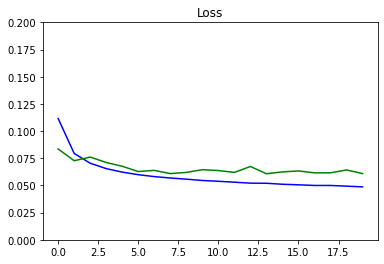

In [13]:
def plot_metrics(metric_name: str, title: str, ylim: float = 5) -> None:
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color="blue", label=metric_name)
    plt.plot(
        history.history[f"val_{metric_name}"],
        color="green",
        label=f"val_{metric_name}",
    )


plot_metrics(metric_name="loss", title="Loss", ylim=0.2);

In [14]:
# Matplotlib config
def visualize_images() -> None:
    plt.rc("image", cmap="gray_r")
    plt.rc("grid", linewidth=0)
    plt.rc("xtick", top=False, bottom=False, labelsize="large")
    plt.rc("ytick", left=False, right=False, labelsize="large")
    plt.rc("axes", facecolor="F8F8F8", titlesize="large", edgecolor="white")
    plt.rc("text", color="a8151a")
    plt.rc("figure", facecolor="F0F0F0")
    # Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(
    left: np.ndarray,
    right: np.ndarray,
    predictions: np.ndarray,
    labels: np.ndarray,
    title: str,
    n: int,
) -> None:
    plt.figure(figsize=(17, 3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28 * n])
    plt.imshow(left)
    plt.figure(figsize=(17, 3))
    plt.yticks([])
    plt.xticks([28 * x + 14 for x in range(n)], predictions)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5:
            t.set_color("red")
            # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28 * n])
    plt.imshow(right);

You can see sample results for 10 pairs of items below.

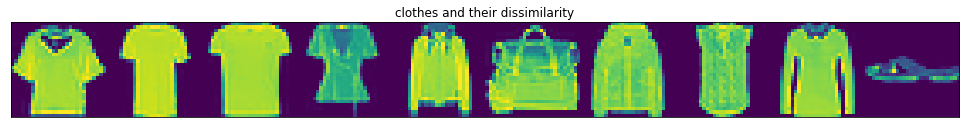

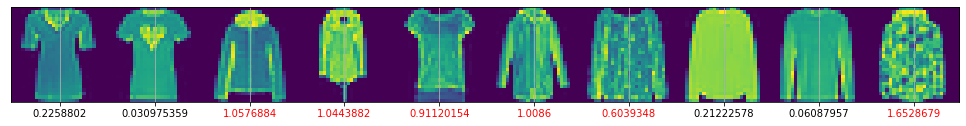

In [15]:
y_pred_train: np.ndarray = np.squeeze(y_pred_train)
indexes: np.ndarray = np.random.choice(len(y_pred_train), size=10)
display_images(
    tr_pairs[:, 0][indexes],
    tr_pairs[:, 1][indexes],
    y_pred_train[indexes],
    tr_y[indexes],
    "clothes and their dissimilarity",
    10,
);